# Load libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
import holidays
import datetime
import tensorflow as tf

# Load data and preprocessing

The data is downloaded manually from [here](https://finance.yahoo.com/quote/GC%3DF/history?period1=1546300800&period2=1705536000&interval=1d&filter=history&frequency=1d&includeAdjustedClose=true)

In [2]:
df = pd.read_csv('/kaggle/input/gold-price-5-year-2019-2024/gold_data_5yr_yahoo.csv')
df.head()

,Date,Open,High,Low,Close*,Adj Close**,Volume
0,01/17/24,2026.5,2026.5,2002.6,2002.6,2002.6,46
1,01/16/24,2051.7,2054.8,2026.0,2026.0,2026.0,46
2,01/15/24,2051.7,2054.8,2051.7,2054.8,2054.8,390
3,01/12/24,2031.1,2057.0,2031.1,2046.7,2046.7,390
4,01/11/24,2025.1,2025.1,2014.3,2014.3,2014.3,97


In [3]:
df.shape

(1271, 7)

In [4]:
df.dtypes

Date            object
Open           float64
High           float64
Low            float64
Close*         float64
Adj Close**    float64
Volume          object
dtype: object

In [5]:
df['Date'] = pd.to_datetime(df.Date, format='%m/%d/%y')
df.drop(columns=['Open', 'Low', 'Close*', 'Adj Close**', 'Volume'], inplace=True)
df.dtypes

Date    datetime64[ns]
High           float64
dtype: object

In [6]:
df.sort_values('Date', inplace=True, ignore_index=True)
df.head()

,Date,High
0,2019-01-02,1286.0
1,2019-01-03,1292.0
2,2019-01-04,1294.2
3,2019-01-07,1286.8
4,2019-01-08,1283.2


In [7]:
# focus on 2024 only
df.iloc[-12:,:]

,Date,High
1259,2024-01-02,2073.7
1260,2024-01-03,2044.0
1261,2024-01-04,2044.5
1262,2024-01-05,2048.1
1263,2024-01-08,2033.7
1264,2024-01-09,2035.8
1265,2024-01-10,2035.6
1266,2024-01-11,2025.1
1267,2024-01-12,2057.0
1268,2024-01-15,2054.8


# Feature engineering part 1
Extract features from the series based on the time index

In [8]:
from datetime import timedelta

#create a dictionary of a holiday calendar for NYSE
nyse_holidays = holidays.NYSE(years=[2019, 2020, 2021, 2022, 2023, 2024])

#make a list of 'important' days
days_important = [] #this would be a list
for d in list(nyse_holidays.keys()):
    days_important.append(d - timedelta(days=3))
    days_important.append(d - timedelta(days=2))
    days_important.append(d - timedelta(days=1))
    days_important.append(d - timedelta(days=0))
    days_important.append(d + timedelta(days=1))

In [9]:
nyse_holidays

{datetime.date(2019, 1, 1): "New Year's Day", datetime.date(2019, 1, 21): 'Martin Luther King Jr. Day', datetime.date(2019, 2, 18): "Washington's Birthday", datetime.date(2019, 4, 19): 'Good Friday', datetime.date(2019, 5, 27): 'Memorial Day', datetime.date(2019, 7, 4): 'Independence Day', datetime.date(2019, 9, 2): 'Labor Day', datetime.date(2019, 11, 28): 'Thanksgiving Day', datetime.date(2019, 12, 25): 'Christmas Day', datetime.date(2020, 1, 1): "New Year's Day", datetime.date(2020, 1, 20): 'Martin Luther King Jr. Day', datetime.date(2020, 2, 17): "Washington's Birthday", datetime.date(2020, 4, 10): 'Good Friday', datetime.date(2020, 5, 25): 'Memorial Day', datetime.date(2020, 7, 3): 'Independence Day (Observed)', datetime.date(2020, 9, 7): 'Labor Day', datetime.date(2020, 11, 26): 'Thanksgiving Day', datetime.date(2020, 12, 25): 'Christmas Day', datetime.date(2021, 1, 1): "New Year's Day", datetime.date(2021, 12, 31): "New Year's Day (Observed)", datetime.date(2021, 1, 18): 'Martin

In [10]:
df.loc[df.Date=='2019-01-21', :]

,Date,High


In [11]:
df['year'] = df.Date.dt.year
df['month'] = df.Date.dt.month
df['day_of_week'] = df.Date.dt.day_of_week
df['days_important'] = df.Date.isin(days_important).astype('int8')

In [12]:
df.drop(columns=['days_important'], inplace=True)

In [13]:
df.head()

,Date,High,year,month,day_of_week
0,2019-01-02,1286.0,2019,1,2
1,2019-01-03,1292.0,2019,1,3
2,2019-01-04,1294.2,2019,1,4
3,2019-01-07,1286.8,2019,1,0
4,2019-01-08,1283.2,2019,1,1


In [14]:
#count working days in each year
print(sum(df.year == 2019))
print(sum(df.year == 2020))
print(sum(df.year == 2021))
print(sum(df.year == 2022))
print(sum(df.year == 2023))

252
253
252
251
251


# Visualization (EDA)

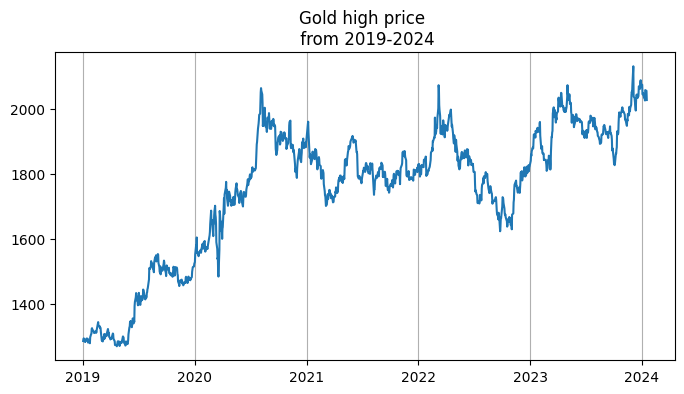

In [15]:
plt.figure(figsize=(8,4))
plt.plot(df.Date, df.High)
plt.title('Gold high price \n from 2019-2024')
plt.grid(axis='x');

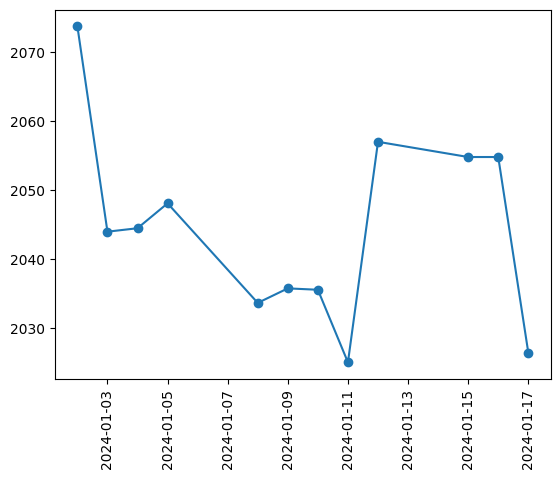

In [16]:
plt.plot(df.iloc[-12:, 0], df.iloc[-12:, 1])
plt.scatter(df.iloc[-12:, 0], df.iloc[-12:, 1])
plt.xticks(rotation=90);

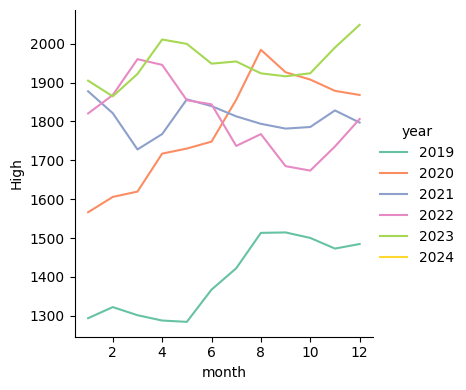

In [17]:
sns.relplot(data=df, x='month', y='High', kind='line', hue='year', palette='Set2',
            errorbar=None, height=4);

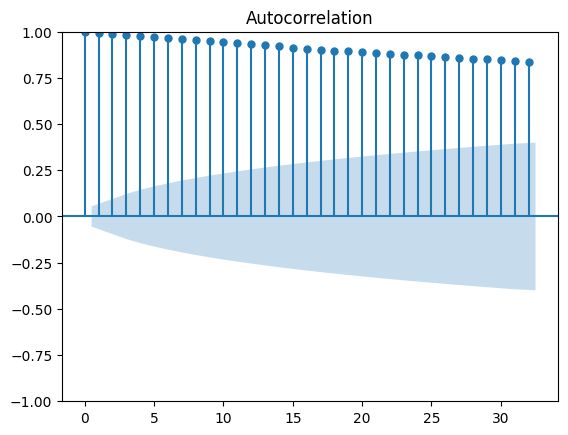

In [18]:
plot_acf(df.High);

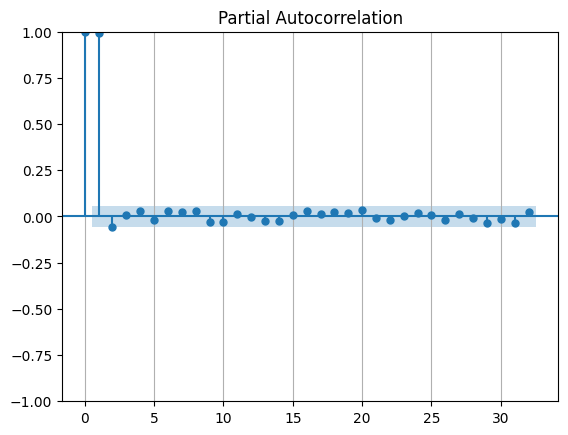

In [19]:
plot_pacf(df.High)
plt.grid(axis='x');

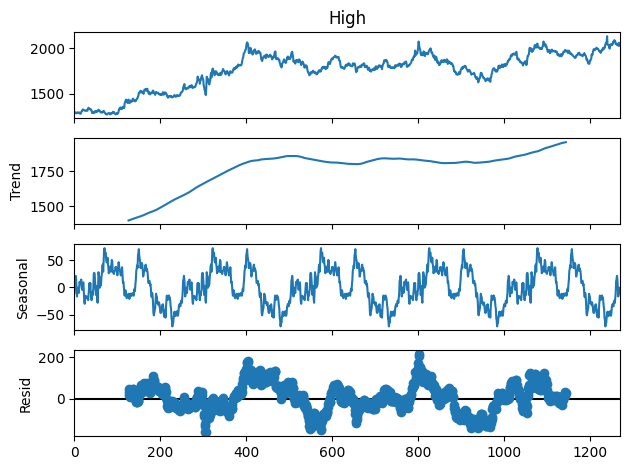

In [20]:
sm.tsa.seasonal_decompose(df.High, period=252).plot();

# Seasonality feature engineering

In [21]:
df['High-1d'] = df.High.shift() #AR(1)
df['High-1w'] = df.High.shift(5)
df['High-1m'] = df.High.shift(25)
df['High-1y'] = df.High.shift(252)

In [22]:
df.head(10)

,Date,High,year,month,day_of_week,High-1d,High-1w,High-1m,High-1y
0,2019-01-02,1286.0,2019,1,2,NaN,NaN,NaN,NaN
1,2019-01-03,1292.0,2019,1,3,1286.0,NaN,NaN,NaN
2,2019-01-04,1294.2,2019,1,4,1292.0,NaN,NaN,NaN
3,2019-01-07,1286.8,2019,1,0,1294.2,NaN,NaN,NaN
4,2019-01-08,1283.2,2019,1,1,1286.8,NaN,NaN,NaN
5,2019-01-09,1289.3,2019,1,2,1283.2,1286.0,NaN,NaN
6,2019-01-10,1284.7,2019,1,3,1289.3,1292.0,NaN,NaN
7,2019-01-11,1291.2,2019,1,4,1284.7,1294.2,NaN,NaN
8,2019-01-14,1293.9,2019,1,0,1291.2,1286.8,NaN,NaN
9,2019-01-15,1292.7,2019,1,1,1293.9,1283.2,NaN,NaN


In [23]:
#remove the 2019 data as a simple way of handling missing data
df = df.loc[df.year>2019,:]

In [24]:
df.head()

,Date,High,year,month,day_of_week,High-1d,High-1w,High-1m,High-1y
252,2020-01-02,1528.7,2020,1,3,1523.4,1499.1,1457.1,1286.0
253,2020-01-03,1552.7,2020,1,4,1528.7,1512.3,1459.8,1292.0
254,2020-01-06,1580.0,2020,1,0,1552.7,1513.8,1461.9,1294.2
255,2020-01-07,1576.3,2020,1,1,1580.0,1515.1,1465.6,1286.8
256,2020-01-08,1604.2,2020,1,2,1576.3,1523.4,1464.4,1283.2


# Split data
Split the data so that the first 75% of the data is for training, while the last 12 data points for testing. The rest is for validation.

In [25]:
total_rows = df.shape[0]
train_X = df.iloc[:int(0.75*total_rows), 4:]
train_y = df.iloc[:int(0.75*total_rows), 1]

valid_X = df.iloc[int(0.75*total_rows):-12, 4:]
valid_y = df.iloc[int(0.75*total_rows):-12, 1]

In [26]:
#use this for confirming that we've split the data correctly
# train_X.head(20)

# Train NN models

In [27]:
tf.random.set_seed(10)

tot_inputs = train_X.shape[1]
inputs = tf.keras.Input(shape=(tot_inputs,), name='input_layer')
x = tf.keras.layers.Dense(tot_inputs*2, activation='relu', name='hidden_layer')(inputs)
outputs = tf.keras.layers.Dense(1, activation='relu', name='output_layer')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs, name='fully-connected-mod')

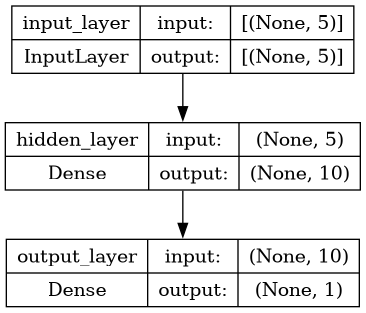

In [28]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [29]:
tot_epochs = 20

model = tf.keras.Model(inputs=inputs, outputs=outputs, name='fully-connected-mod')
model.compile(optimizer='Adam', loss='mean_absolute_error', 
              metrics=['mean_squared_error', 'mean_absolute_error', 
                       'mean_squared_logarithmic_error'])

history = model.fit(x=train_X, y=train_y, validation_data=(valid_X, valid_y), 
                    batch_size=128, epochs=tot_epochs)

Epoch 1/20
6/6 [==============================] - 1s 70ms/step - loss: 1167.1906 - mean_squared_error: 1372230.5000 - mean_absolute_error: 1167.1906 - mean_squared_logarithmic_error: 1.1101 - val_loss: 1213.6663 - val_mean_squared_error: 1476206.8750 - val_mean_absolute_error: 1213.6663 - val_mean_squared_logarithmic_error: 0.9444
Epoch 2/20
6/6 [==============================] - 0s 12ms/step - loss: 1083.4193 - mean_squared_error: 1183030.7500 - mean_absolute_error: 1083.4193 - mean_squared_logarithmic_error: 0.8599 - val_loss: 1124.7302 - val_mean_squared_error: 1268091.6250 - val_mean_absolute_error: 1124.7302 - val_mean_squared_logarithmic_error: 0.7362
Epoch 3/20
6/6 [==============================] - 0s 11ms/step - loss: 995.4473 - mean_squared_error: 998732.6250 - mean_absolute_error: 995.4473 - mean_squared_logarithmic_error: 0.6556 - val_loss: 1023.1110 - val_mean_squared_error: 1049235.1250 - val_mean_absolute_error: 1023.1110 - val_mean_squared_logarithmic_error: 0.5502
Epoc

In [30]:
history.history.keys()

dict_keys(['loss', 'mean_squared_error', 'mean_absolute_error', 'mean_squared_logarithmic_error', 'val_loss', 'val_mean_squared_error', 'val_mean_absolute_error', 'val_mean_squared_logarithmic_error'])

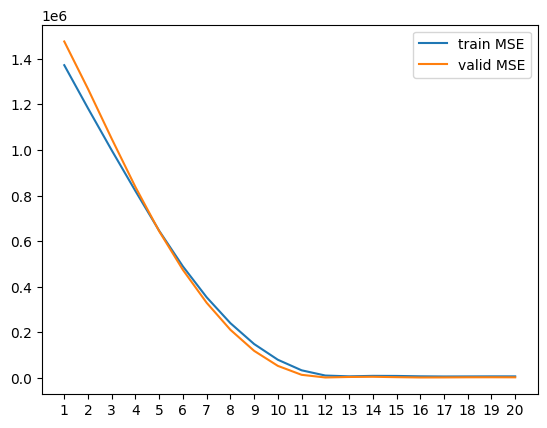

In [31]:
plt.plot(history.history['mean_squared_error'], label='train MSE')
plt.plot(history.history['val_mean_squared_error'], label='valid MSE')
plt.xticks(ticks=np.arange(tot_epochs), labels=np.arange(1, (tot_epochs+1)))
plt.legend();

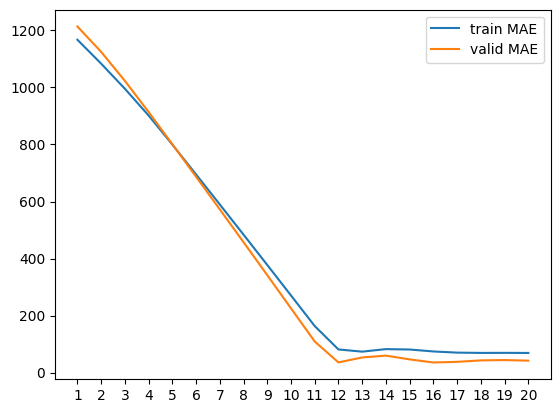

In [32]:
plt.plot(history.history['mean_absolute_error'], label='train MAE')
plt.plot(history.history['val_mean_absolute_error'], label='valid MAE')
plt.xticks(ticks=np.arange(tot_epochs), labels=np.arange(1, (tot_epochs+1)))
plt.legend();

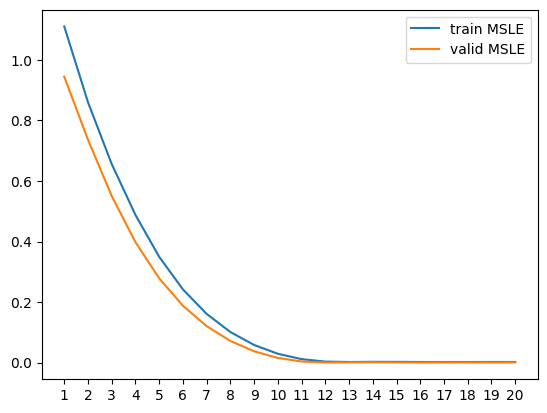

In [33]:
plt.plot(history.history['mean_squared_logarithmic_error'], label='train MSLE')
plt.plot(history.history['val_mean_squared_logarithmic_error'], label='valid MSLE')
plt.xticks(ticks=np.arange(tot_epochs), labels=np.arange(1, (tot_epochs+1)))
plt.legend();

# Predict

In [34]:
#retrain on all data
pred_dict = {}
for i in range(10):
    model = tf.keras.Model(inputs=inputs, outputs=outputs, name='fully-connected-mod')
    model.compile(optimizer='Adam', loss='mean_absolute_error', 
                  metrics=['mean_squared_error', 'mean_absolute_error', 
                           'mean_squared_logarithmic_error'])
    model.fit(x=df.iloc[:-12, 4:], y=df.iloc[:-12, 1], batch_size=128, epochs=20, verbose=0)
    prediction = model.predict(df.iloc[-12:, 4:])
    pred_dict[f'pred_{i}'] = prediction[:, 0]

1/1 [==============================] - 0s 69ms/step


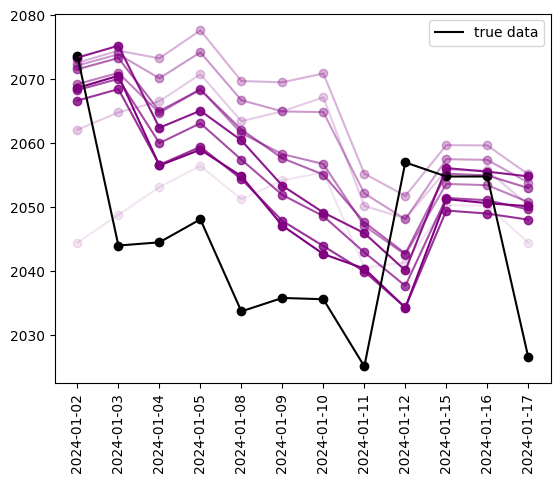

In [35]:
days_to_pred = pd.date_range(start='2024-01-02', end='2024-01-17', freq='B')
days_to_pred = [i.date() for i in days_to_pred]

for i in range(10):
    plt.plot(pred_dict[f'pred_{i}'], color='purple', alpha=(i+1)/10)
    plt.scatter(np.arange(12), pred_dict[f'pred_{i}'], color='purple', alpha=(i+1)/10)
    
plt.plot(np.arange(12), df.High[-12:], label='true data', color='black')
plt.scatter(np.arange(12), df.High[-12:], color='black')
plt.xticks(ticks=np.arange(12), labels=days_to_pred, rotation=90)
plt.legend();